In [13]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

### Read & Explore Data

In [14]:
words = open('names.txt', 'r').read().splitlines()

In [15]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [16]:
len(words)

32033

In [17]:
min(len(w) for w in words), max(len(w) for w in words)

(2, 15)

## Bigram Model

### Create a Bigram Frequency Matrix

In [37]:
b = {}

for w in words:
  chs = ['<S>'] + list(w) + ['<E>']
  for ch1, ch2 in zip(chs, chs[1:]):
    bigram = (ch1, ch2)
    b[bigram] = b.get(bigram, 0) + 1

In [38]:
pairs = sorted(b.items(), key=lambda kv: -kv[1])
pairs[:10]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963)]

In [39]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}


In [40]:
N = torch.zeros((27, 27), dtype=torch.int32) # 26 chars + 2 special chars 

In [41]:
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    N[ix1][ix2] = N[ix1][ix2] + 1

(-0.5, 26.5, 26.5, -0.5)

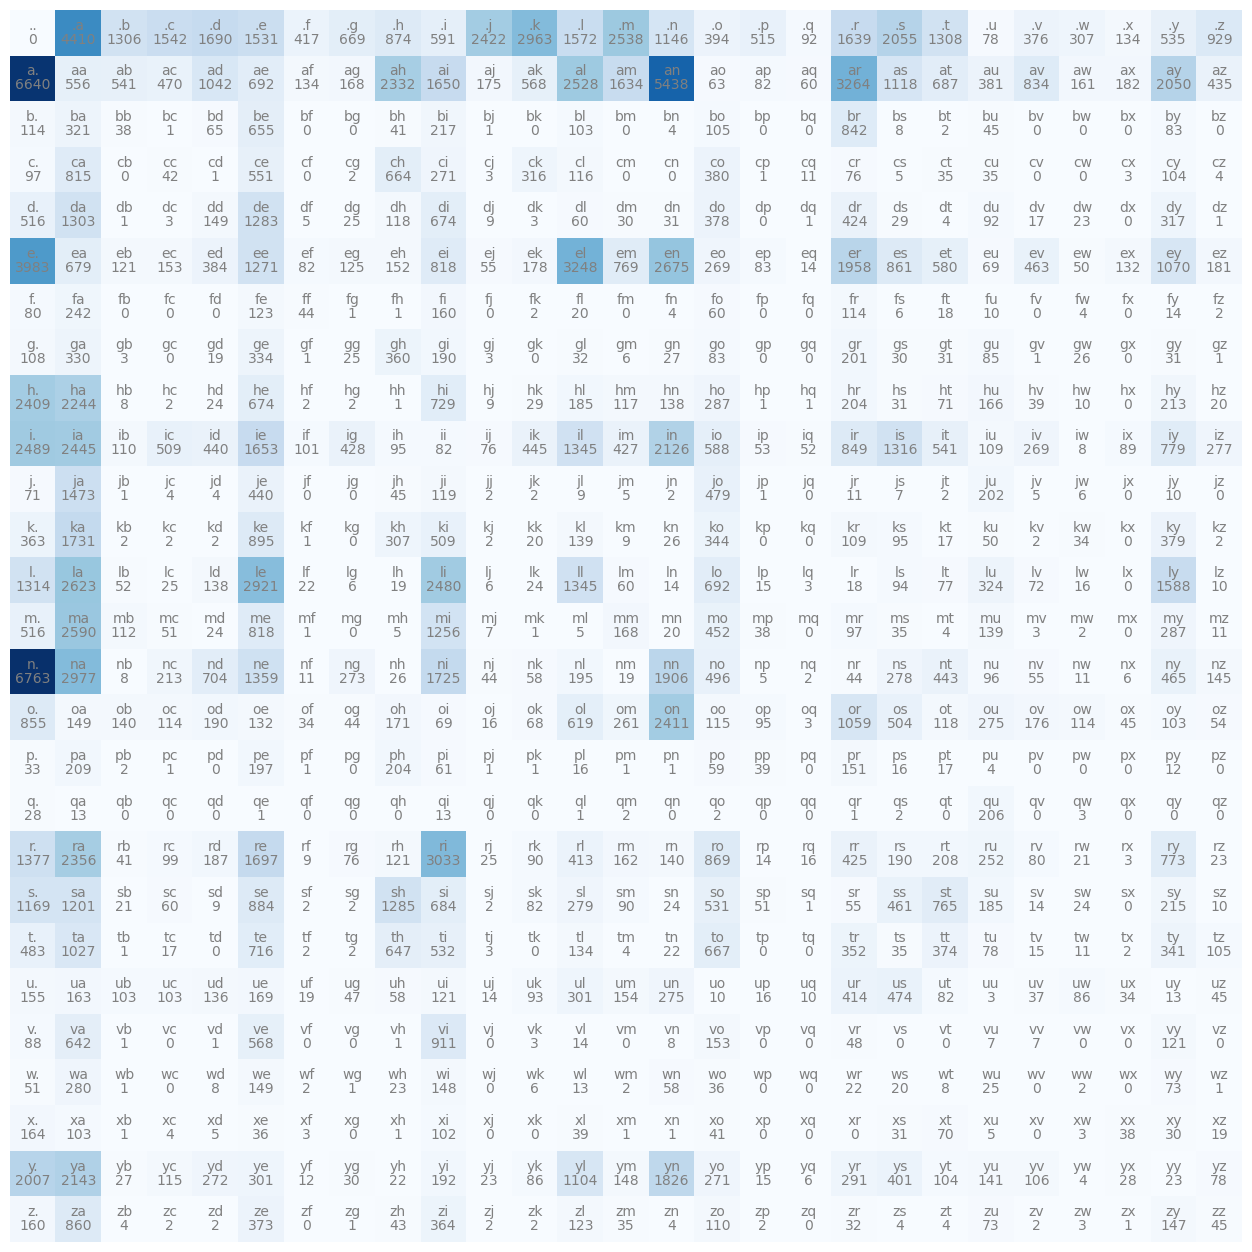

In [42]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')

for i in range(len(itos)):
  for j in range(len(itos)):
    chstr = itos[i] + itos[j]
    plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
    plt.text(j, i, N[i,j].item(), ha='center', va='top', color='gray')
plt.axis('off')

### Sample from the Frequency Matrix

In [43]:
p = N[0].float()
p = p / p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [44]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=20, replacement=True, generator=g)
ix

tensor([13, 19, 14,  1,  1, 20, 20,  1, 13, 13, 13, 11, 23, 13, 19, 18, 26, 11,
         7, 19])

In [45]:
g = torch.Generator().manual_seed(2147483647)

for i in range(20):
  out = []
  ix = 0
  while True:
    p = N[ix].float()
    p = p/p.sum()
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

mor.
axx.
minaymoryles.
kondlaisah.
anchshizarie.
odaren.
iaddash.
h.
jhinatien.
egushl.
h.
br.
a.
jayn.
ilemannariaenien.
be.
f.
akiinela.
trttanakeroruceyaaxatona.
lamoynayrkiedengin.


### Improving Efficiency - Vectorized Normalization

In [52]:
P = (N+1).float()
# Adding 1 above to each pair to smmoth it out and avoid problem where pairs occurs 0 times, making log likelihood -inf as in the 3rd example below.
P /= P.sum(dim = 1, keepdim=True)

In [53]:
g = torch.Generator().manual_seed(2147483647)

for i in range(20):
  out = []
  ix = 0
  while True:
    p = P[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

mor.
axx.
minaymoryles.
kondlaisah.
anchshizarie.
odaren.
iaddash.
h.
jhinatien.
egushl.
h.
br.
a.
jayn.
ilemannariaenien.
be.
f.
akiinela.
trttanakeroruceyaaxatona.
lamoynayrkiedengin.


### Loss Function

In [54]:
log_liklihood = 0.0
n = 0

for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_liklihood += logprob
    n += 1
print(f'{log_liklihood=}')
nll = -log_liklihood
print(f'{nll=}')
print(f'Normalized Negative Log Likelihood: {nll/n}')

log_liklihood=tensor(-559951.5625)
nll=tensor(559951.5625)
Normalized Negative Log Likelihood: 2.4543561935424805


GENERAL GOAL

- Maximize likelihood of the data w.r.t model parameters (statistical modeling)
- Equivalent to maximizing the log likelihood (as  log is monotonic)
- Equivalent to minimizing the negative log likelihood
- Equivalent to minimizing the average negative log likelihood

#### Example 1

In [55]:
# Check probability for new word
log_liklihood = 0.0
n = 0

for w in ["josh"]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_liklihood += logprob
    n += 1
    print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')
print(f'{log_liklihood=}')
nll = -log_liklihood
print(f'{nll=}')
print(f'Normalized Negative Log Likelihood: {nll/n}')

.j: 0.0756 -2.5826
jo: 0.1640 -1.8079
os: 0.0634 -2.7578
sh: 0.1581 -1.8444
h.: 0.3153 -1.1542
log_liklihood=tensor(-10.1469)
nll=tensor(10.1469)
Normalized Negative Log Likelihood: 2.029371738433838


We can see a okish probability (near to what we have on iven dataset) which indicates this as a resonable word.

#### Example 2

In [56]:
# Check probability for new word
log_liklihood = 0.0
n = 0

for w in ["abcd"]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_liklihood += logprob
    n += 1
    print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')
print(f'{log_liklihood=}')
nll = -log_liklihood
print(f'{nll=}')
print(f'Normalized Negative Log Likelihood: {nll/n}')

.a: 0.1376 -1.9835
ab: 0.0160 -4.1363
bc: 0.0007 -7.1974
cd: 0.0006 -7.4841
d.: 0.0936 -2.3686
log_liklihood=tensor(-23.1699)
nll=tensor(23.1699)
Normalized Negative Log Likelihood: 4.633984565734863


Much lesser probability compared to above, pairs `bc` & `cd` are very less probable.

#### Example 3

In [57]:
# Check probability for new word
log_liklihood = 0.0
n = 0

for w in ["abcdjq"]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_liklihood += logprob
    n += 1
    print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')
print(f'{log_liklihood=}')
nll = -log_liklihood
print(f'{nll=}')
print(f'Normalized Negative Log Likelihood: {nll/n}')

.a: 0.1376 -1.9835
ab: 0.0160 -4.1363
bc: 0.0007 -7.1974
cd: 0.0006 -7.4841
dj: 0.0018 -6.3141
jq: 0.0003 -7.9817
q.: 0.0970 -2.3331
log_liklihood=tensor(-37.4303)
nll=tensor(37.4303)
Normalized Negative Log Likelihood: 5.347180366516113


Here, Normalized Negative Log Likelihood would have been `inf` if we wouldn't have smoothed out the counts (by adding 1 to each pair). The pair `jq` doesn't occur in the dataset at all, but we add 1 so that probability doesn't stay 0.

## Neural Network Model - v1

### Create training data

In [35]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

numChars = len(stoi)

In [36]:
xs, ys = [], []

for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [37]:
xs, ys

(tensor([ 0,  5, 13,  ..., 25, 26, 24]),
 tensor([ 5, 13, 13,  ..., 26, 24,  0]))

### Model Idea

In [21]:
xenc = F.one_hot(xs, num_classes=27).float()

torch.Size([228146, 27])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.]])


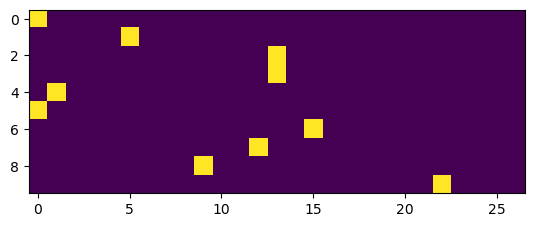

In [22]:
print(xenc.shape)
print(xenc)
plt.imshow(xenc[:10, :])

In [23]:
W = torch.randn((len(stoi), len(stoi)))
(xenc @ W).shape

torch.Size([228146, 27])

IMP

`(xenc @ W)[1000][13]` is same as `(xenc[100] * W[:, 13]).sum()`. It is done efficiently by matrix multiplication operator.

This indicates 3rd example from the dataset firing 13th neuron from the W layer.

In [27]:
(xenc @ W)[1000]

tensor([ 0.3544,  0.4698,  0.4821, -0.0581, -0.0391,  1.9744, -0.2236,  0.1008,
         0.7783, -0.9823, -0.1076,  0.0364, -0.0910, -0.4529, -0.6501,  1.3276,
        -0.6908, -0.8167,  0.5036, -0.4115, -1.2666, -0.3887,  1.6006,  1.2741,
         0.9016,  1.0295, -1.4005])

Now we have 27 values for each of the training examples, but this values can be negative as well. To interpret them as probabilities, we take exponential of it, which makes negative values positive and positie, even more positive.

In [28]:
logits = xenc @ W # Log-counts
counts = logits.exp() # Equivalent to N in bigram approach
probs = counts/ counts.sum(1, keepdims = True)

In [31]:
print(probs.shape)
print(probs[1000])
print(probs[1000].sum())

torch.Size([228146, 27])
tensor([0.0322, 0.0362, 0.0366, 0.0213, 0.0217, 0.1628, 0.0181, 0.0250, 0.0492,
        0.0085, 0.0203, 0.0234, 0.0206, 0.0144, 0.0118, 0.0852, 0.0113, 0.0100,
        0.0374, 0.0150, 0.0064, 0.0153, 0.1120, 0.0808, 0.0557, 0.0633, 0.0056])
tensor(1.)


HOW TO INTERPRET THE `probs` matrix?

1. Our first bigram example is `('.', 'e')`. That means `.` is followed by `e`. So the input in this case is `.`, and we expect output probability for `e` maximum by the end of training.
2. We first got index of `.`, then we One-Hot encoded it and it went into the neural network.
3. It was multiplied by matrix `W` of size (27, 27) to give output with size of 27 for this example.
4. We convert this output into probability distribution for each example by first exponentiation and followed by normaliztion.

### Approach

In [58]:
# Randomly initiate 27 neurons' weights. Each neuron recives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((numChars, numChars), generator=g, requires_grad=True)

In [46]:
# Forward Pass

xenc = F.one_hot(xs, num_classes=numChars).float() # Input to the network: One-hot encoding
logits = xenc @ W # predict log-counts using current weights
counts = logits.exp() # Counts (non-negative) equivalent to N
probs = counts/ counts.sum(1, keepdim=True) # probabilities for next charater by normalizing

# Last two setps are together called as 'Softmax'!

In [47]:
probs.shape

torch.Size([228146, 27])

#### How to Calculate Loss?

In [48]:
nlls = torch.zeros(5)

for i in range(5):
  x = xs[i].item()
  y = ys[i].item()

  print('---')
  print(f'Bigram Example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
  print(f'Input to neural net: {x}')
  print(f'Output probabilities from neural net: {probs[i]}')
  print(f'Label (Actual next character): {y}')
  p = probs[i, y]
  print(f'Probability assigned by model to the correct character: {p.item()}')
  logp = torch.log(p)
  print(f'Log Likelihood: {logp}')
  nll = -logp
  print(f'Negative Log Likelihood: {nll}')
  nlls[i] = nll

print('===')
print(f'Average Negative Log Likelihood i.e Loss: {nlls.mean().item()}')


---
Bigram Example 1: .e (indexes 0,5)
Input to neural net: 0
Output probabilities from neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
Label (Actual next character): 5
Probability assigned by model to the correct character: 0.012286253273487091
Log Likelihood: -4.3992743492126465
Negative Log Likelihood: 4.3992743492126465
---
Bigram Example 2: em (indexes 5,13)
Input to neural net: 5
Output probabilities from neural net: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
Label (Actual next character): 13
Probability assigned by model to the correct character: 0.018050702288746834
Log Likelihood: 

We can write above loss steps in vectorized form as follows:

In [56]:
loss = - probs[torch.arange(5), ys[:5]].log().mean()
loss

tensor(3.7693)

### Final Data + Model

In [77]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

numChars = len(stoi)

In [78]:
xs, ys = [], []

for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [79]:
# Randomly initiate 27 neurons' weights. Each neuron recives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((numChars, numChars), generator=g, requires_grad=True)

In [80]:
for k in range(100):
  # Forward Pass

  xenc = F.one_hot(xs, num_classes=numChars).float() # Input to the network
  logits = xenc @ W # predict log-counts using current weights
  counts = logits.exp() # Counts (non-negative) equivalent to N
  probs = counts/ counts.sum(1, keepdim=True) # probabs for next char by normalizing
  loss = - probs[torch.arange(len(ys)), ys].log().mean()

  # Backward Pass
  W.grad = None
  loss.backward()

  # Update weights
  W.data += -50 * W.grad

  print(k, loss.data)

0 tensor(3.7590)
1 tensor(3.3711)
2 tensor(3.1540)
3 tensor(3.0204)
4 tensor(2.9277)
5 tensor(2.8604)
6 tensor(2.8097)
7 tensor(2.7701)
8 tensor(2.7381)
9 tensor(2.7115)
10 tensor(2.6890)
11 tensor(2.6697)
12 tensor(2.6529)
13 tensor(2.6383)
14 tensor(2.6254)
15 tensor(2.6140)
16 tensor(2.6039)
17 tensor(2.5948)
18 tensor(2.5867)
19 tensor(2.5794)
20 tensor(2.5728)
21 tensor(2.5668)
22 tensor(2.5613)
23 tensor(2.5563)
24 tensor(2.5516)
25 tensor(2.5474)
26 tensor(2.5434)
27 tensor(2.5397)
28 tensor(2.5363)
29 tensor(2.5332)
30 tensor(2.5302)
31 tensor(2.5274)
32 tensor(2.5248)
33 tensor(2.5223)
34 tensor(2.5200)
35 tensor(2.5179)
36 tensor(2.5158)
37 tensor(2.5139)
38 tensor(2.5121)
39 tensor(2.5103)
40 tensor(2.5087)
41 tensor(2.5071)
42 tensor(2.5057)
43 tensor(2.5043)
44 tensor(2.5029)
45 tensor(2.5017)
46 tensor(2.5005)
47 tensor(2.4993)
48 tensor(2.4982)
49 tensor(2.4971)
50 tensor(2.4961)
51 tensor(2.4952)
52 tensor(2.4942)
53 tensor(2.4934)
54 tensor(2.4925)
55 tensor(2.4917)
56

We are now acheiving similar loss to bigram model using this bigram based neural network using gradient descent. We can make model more complex to improve accuracy, only forward pass will chnage in this case, making this much more efficient and flexible approach.

In [83]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  out = []
  ix = 0
  while True:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=numChars).float() # Input to the network
    logits = xenc @ W # predict log-counts using current weights
    counts = logits.exp() # Counts (non-negative) equivalent to N
    probs = counts/ counts.sum(1, keepdim=True) # probabs for next char by normalizing
    ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

mor.
axwaninaymoryles.
kondmaisah.
anchshizarie.
odaren.
